### Malaria Detection

<hr>

#### Background

Malaria is one of the most common infectious diseases and global public health challenge to deal with. It is caused by a **parasite** that is transmitted through the bite of infected female *Anopheles* **mosquitoes**. The parasite that causes malaria is a microscopic, single-celled organism called **Plasmodium**.

Malaria can be fatal but can be cured if detected early on. It is commonly found in the tropical and sub-tropical areas of Africa, South America and Asia. As such, it is estimated to have infected more than 198 million cases and caused 584,000 deaths in 2013 and increasing to 219 million cases with 435,000 deaths in 2017. The African region carries a high share of the global malaria burden with roughly 92% of total malaria cases and 93% of malaria deaths ([reference](https://www.who.int/news-room/fact-sheets/detail/malaria)).

<img src='../img/malaria_distribution_map_2013.png' alt='Drawing' style='width: 400px;'/>

*A map shows the distribution of malaria around the world (cited from [source](https://www.who.int/malaria/publications/world_malaria_report_2014/wmr-2014-no-profiles.pdf?ua=1))*

<br>

#### How is malaria diagnosed?

- The most accurate way to diagnose malaria is by taking a drop of blood, smearing it on a slide and then examining it under a microscope to look for malaria parasites inside the **red blood cells**
- However, this method relies on the availability of clinic with a microscope, electricity and trained technician to look at the slides. This presents a big challenge to some countries, especially Africa region.
- Most recently, rapid diagnostic tests have been introduced. These involve dipping a test stick into a drop of blood to test for the presense of proteins from the parasite. If the malaria parasite is present in the blood sample bands appear on the test stick, some of these tests are even able to identify which species of *Plasmodium* is present. These are much more convenient than the traditional way and remove the high-tech equipment with the outcome can be received within 15 minutes.

<img src='../img/malaria_microscope_stages2.jpg' alt='Drawing' style='width: 450px;'/>

*The above image is from Microscope of a blood smear taken from someone with malaria: 1. Healthy red blood cell; 2. Malaria parasites developing within infected red blood cells; 3. Malaria parasites about to burst out of red blood cell (Image credit: Will Hamilton).*

<br>

#### Motivation

- The objective behind the data set is to help reducing the burden for microscopists in resource-constrained regions and improve diagnostic accuracy. Giemsa-stained thin blood smear slides from 150 P. falciparum-infected and 50 healthy patients were collected and photographed at Chittagong Medical College Hospital, Bangladesh (data set can obtain from [here](https://ceb.nlm.nih.gov/repositories/malaria-datasets/)).

- This notebook will follow the general machine learning workflow
  1. Examine and understand the data by visualizing the images
  2. Build the input pipeline for feeding the image to model
  3. Compose the model
    * Load the pretrained base model (in this case, MobileNetV2)
    * Stack our specific classification layers on top
  4. Train the model for this specific task
  5. Evaluate model

<br><br>

**Reference**:
- https://www.yourgenome.org/facts/what-is-malaria

In [1]:
import os
import sys
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 255)

# image related 
import cv2
from PIL import Image

# sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score 
from sklearn.metrics import recall_score, confusion_matrix, roc_auc_score

# tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow.keras.backend as K

# visualize related
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display, HTML
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

import tensorflow as tf

W0614 10:52:05.730700 13512 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
C:\Users\n.satsawat\Anaconda3_\lib\site-packages\dask\config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [2]:
SEED = 4895
PATH = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()
os.chdir(PATH)
np.random.seed(SEED)

The data is stored individually in each directory (parasitized vs. uninfected).

In [3]:
os.listdir('../data/cell_images')

['Parasitized', 'Uninfected']

We can create the function to automatically see how many files we have, the file names and extensions.

In [4]:
def list_files_and_extensions(directory: str):
    """
    Function to list all file names with their extensions
    @Args:
      directory (str): the name of the directory to loop 
      
    Return:
      List of file names and extensions
    """
    filenames = []
    extensions = []
    try:
        if len(os.listdir(directory)) == 0:
            print('Warning: "%s" directory has no file.' % directory)

        else:
            for all_ in os.listdir(directory):
                filenames.append(all_.split('.')[0])
                extensions.append(all_.split('.')[1])
            
            print('There are total of %s files in "%s" directory' % (len(filenames), directory))
            
    except FileNotFoundError:
        print('Error %s occured!!' % sys.exc_info()[0])
        print('"%s" directory is not existed' % directory)
        
    except ValueError:
        print('Error %s occured!!' % sys.exc_info()[0])
        
    return filenames, extensions


In [5]:
infect_file_list, infect_file_exts = list_files_and_extensions('../data/cell_images/Parasitized')
uninfect_file_list, uninfect_file_exts = list_files_and_extensions('../data/cell_images/Uninfected')

There are total of 13780 files in "../data/cell_images/Parasitized" directory
There are total of 13780 files in "../data/cell_images/Uninfected" directory


Then we can explore the file extensions and keep the extensions which we are interested in.

In [6]:
dict((x, infect_file_exts.count(x)) for x in set(infect_file_exts))

{'db': 1, 'png': 13779}

There are some `db` file format, which is not desired in this case. Let's remove it from the list.

In [7]:
def remove_from_list(files_list: list, exts_list: list,
                     ext_to_remove: str='db'):
    """
    Function to remove specific extension from the list; 
      This will remove the file name from its list as well.
    @Args:
      files_list (list): the list of file name
      exts_list (list): the list of file extension
      ext_to_remove (str): The extension which will be removed; default is 'db'
      
    Return:
      The cleansed lists of file name and extension
    """
    try:
        idx_ = [i for i, s in enumerate(exts_list) if ext_to_remove in s]
        idx_ = idx_[0]
        print('Removing index %d' % (idx_))
        del exts_list[idx_]
        del files_list[idx_]
        
    except (TypeError, IndexError):
        print('Error %s occured!!' % sys.exc_info()[0])
        
    return files_list, exts_list



In [8]:
infect_file_list, infect_file_exts = remove_from_list(infect_file_list, infect_file_exts)
uninfect_file_list, uninfect_file_exts = remove_from_list(uninfect_file_list, uninfect_file_exts)

Removing index 13779
Removing index 13779


#### Visualize the image

Let's quickly look at the given image.

In [9]:
def visualize_images(file_list: list, ext_list: list, 
                     mode: str='infect'):
    """
    Function to plot the top images of given class
    @Args:
      file_list (list): the list contains the file name
      ext_list (list): the list contains the fil extensions
      mode (str): the string indicates which folder to include; Default is 'infect'.
    
    Return:
      No object returned only visualization on console / notebook
    """
    data_path_ = '../data/cell_images'
    if mode == 'infect':
        full_path = os.path.join(data_path_, 'Parasitized')
        
    else:
        full_path = os.path.join(data_path_, 'Uninfected')
        
    plt.figure(figsize=(14, 10))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        img = cv2.imread(os.path.join(full_path, file_list[i] + '.' + ext_list[i]))
        plt.imshow(img)
        plt.title('%s' % file_list[i], size=6.5)
        plt.xticks([])
        plt.xlabel('%s' % mode, size=7)
        plt.yticks([])
        
    plt.show();
    return None

    

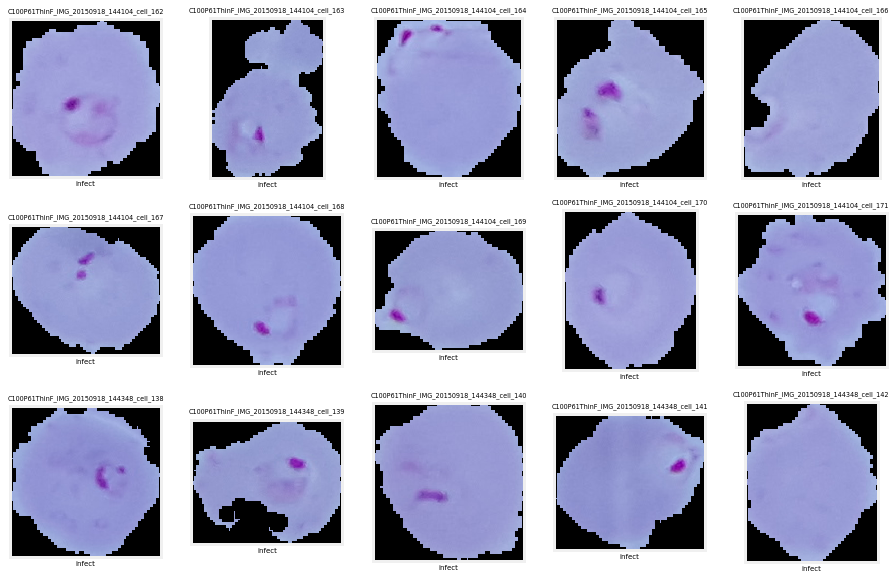

In [10]:
visualize_images(infect_file_list, infect_file_exts, mode='infect')

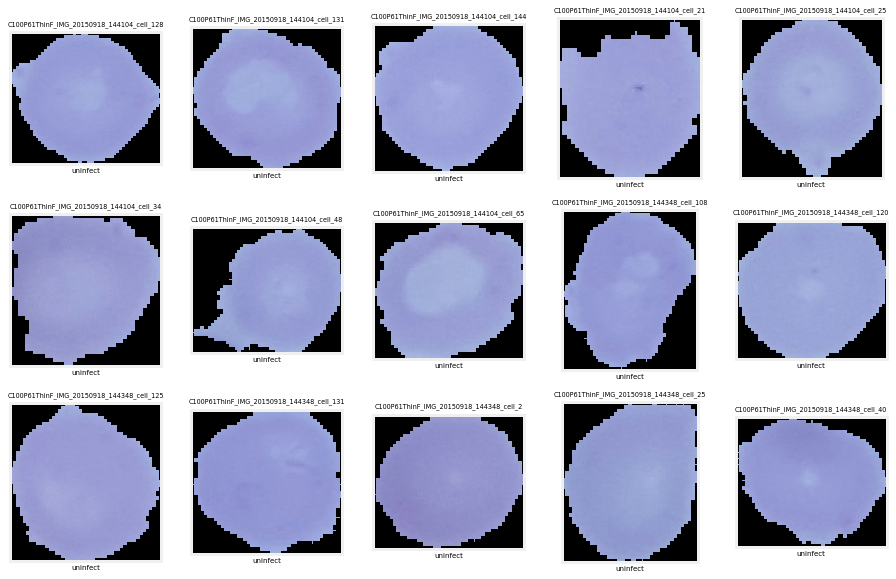

In [11]:
visualize_images(uninfect_file_list, uninfect_file_exts, mode='uninfect')

__Quick Observation:__

- The image name consists of patient ID and the date time stamp.
- The image sizes are not the same, this will need to take into account during the preprocessing.
- The cell infected by **Malaria** shows the purple spot within the cell. However, the uninfected cells do not show any spot.

#### Prepare the data pipeline

In normal circumstances, we would load all images into the memory and shuffle the data onto train and test dataset (or, even, validation dataset). However, if there're a lot of images and the resolution may be too big to fit onto the memory.

We may consider to build the pipeline to transport data onto the model instead.

- Create function to create new folders: train, test and validation, if required.
- Create list containing all relative path to files, which will be shuffled
- Use those file lists to randomly copy to train and test folder

In [12]:
def create_all_file_list(infect_files: list, infect_exts: list, 
                         uninfect_files: list, uninfect_exts: list):
    """
    Function to concatenate the infect files and uninfect files together
    @Args:
      infect_files (list): The list of file names for infected images
      infect_exts (list): The list of extensions for infected images
      uninfect_files (list): The list of file names for uninfect images
      uninfect_exts (list): The list of extensions for uninfect images
    
    Return:
      The list of all files with labels
    """
    _all_file = []
    _all_label = []
    infect_files_ = [x + '.' + y for x, y in zip(infect_files, infect_exts)]
    infect_files_ = ['../data/cell_images/Parasitized/' + i for i in infect_files_]
    infect_label_ = [1] * len(infect_files_)
    uninfect_files_ = [x + '.' + y for x, y in zip(uninfect_files, uninfect_exts)]
    uninfect_files_ = ['../data/cell_images/Uninfected/' + i for i in uninfect_files_]
    uninfect_label_ = [0] * len(uninfect_files_)
    _all_file = infect_files_ + uninfect_files_
    _all_label = infect_label_ + uninfect_label_
    return _all_file, _all_label


def create_folder(dir_name: str, 
                  data_path: str='../data/'):
    """
    Function to create new folders on the given data_path
    @Args:
      dir_name (str): the directory name to be created
      data_path (str): the designated folder where new folder will be on
      
    Return:
      None object will return
    """
    _new_dir = os.path.join(data_path, dir_name)
    try:
        os.mkdir(_new_dir)
        print('Create "%s" directory success!!' % dir_name)
        
    except FileExistsError:
        print('"%s" is already existed!!' % _new_dir)
        
    return None


def copy_image_to_folder(source_file: str, designated_folder: str):
    """
    Function to copy image to designated folder
    @Args:
      source_file (str): The relative path to the image file
      designated_folder (str): The folder where will be the designated folder of the copied items
      
    Return:
      None object
    """
    _new_file_name = source_file.split('/')[3] + '_' + source_file.split('/')[4]
    designated_folder = os.path.join(designated_folder, source_file.split('/')[3])
    img_ = Image.open(source_file)
    img_.save(os.path.join(designated_folder, _new_file_name))
    return None



In [13]:
all_file_list, all_label_list = create_all_file_list(infect_file_list, infect_file_exts, 
                                                     uninfect_file_list, uninfect_file_exts)
mapping_df = pd.DataFrame({'file_id': all_file_list, 
                           'label': all_label_list})
display(mapping_df.head(5))

,file_id,label
0,../data/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png,1
1,../data/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png,1
2,../data/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png,1
3,../data/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_165.png,1
4,../data/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_166.png,1


Then we can shuffle the row for further usage.

In [14]:
mapping_df_shuffled = sklearn.utils.shuffle(mapping_df)
mapping_df_shuffled.reset_index(drop=True, inplace=True)
display(mapping_df_shuffled.head(7))

,file_id,label
0,../data/cell_images/Uninfected/C202ThinF_IMG_20151015_152333_cell_45.png,0
1,../data/cell_images/Parasitized/C129P90ThinF_IMG_20151004_133703_cell_91.png,1
2,../data/cell_images/Uninfected/C125P86ThinF_IMG_20151004_102132_cell_95.png,0
3,../data/cell_images/Parasitized/C80P41ThinF_IMG_20150817_111121_cell_155.png,1
4,../data/cell_images/Parasitized/C70P31_ThinF_IMG_20150813_131708_cell_2.png,1
5,../data/cell_images/Uninfected/C157P118ThinF_IMG_20151115_163915_cell_15.png,0
6,../data/cell_images/Uninfected/C49P10thinF_IMG_20150724_102951_cell_130.png,0


In [15]:
training_set, test_set = train_test_split(mapping_df_shuffled, test_size=0.2, random_state=SEED)
validation_set, testing_set = train_test_split(test_set, test_size=0.5, random_state=SEED)

Quickly plot how the label distributes across 3 data sets.

- The labels are distributed close to 50% across all data sets.
- We can use **image augmentation** on training data set to increase the representation of each label.

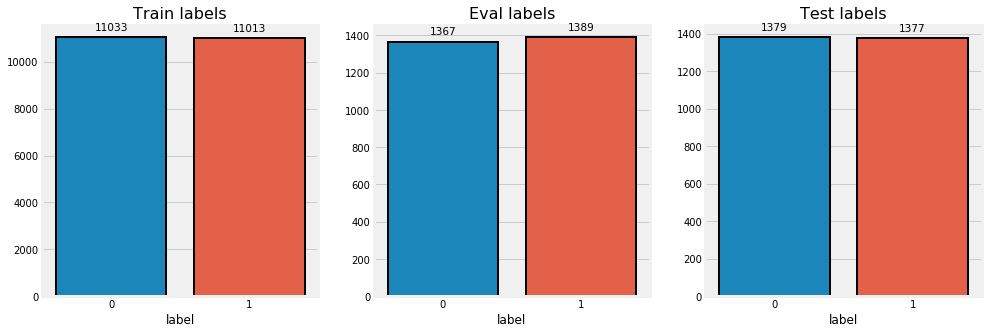

In [16]:
plt.figure(figsize = (15 ,5))
n = 0 
for z , j in zip([training_set['label'], validation_set['label'], testing_set['label']] , 
                 ['Train labels','Eval labels','Test labels']):
    n += 1
    plt.subplot(1, 3, n)
    ax = sns.countplot(x=z, linewidth=2, edgecolor='k'*z.nunique())
    for p in ax.patches:
        ax.annotate(format(p.get_height(), 'd'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va='center', 
                    xytext = (0, 10), fontsize=10.5,
                    textcoords = 'offset points')
        
    plt.ylabel('')
    plt.title(j, fontsize=16)
    
plt.show();

In [17]:
create_folder('Train/Parasitized')
create_folder('Train/Uninfected')
create_folder('Test/Parasitized')
create_folder('Test/Uninfected')
create_folder('Eval/Parasitized')
create_folder('Eval/Uninfected')

"../data/Train/Parasitized" is already existed!!
"../data/Train/Uninfected" is already existed!!
"../data/Test/Parasitized" is already existed!!
"../data/Test/Uninfected" is already existed!!
"../data/Eval/Parasitized" is already existed!!
"../data/Eval/Uninfected" is already existed!!


In [18]:
for i in range(training_set.shape[0]):
    copy_image_to_folder(training_set.iloc[i, 0], designated_folder='../data/Train/')
    if i % 1000 == 0:
        print('Moved %d completed!' % i)

Moved 0 completed!
Moved 1000 completed!
Moved 2000 completed!
Moved 3000 completed!
Moved 4000 completed!
Moved 5000 completed!
Moved 6000 completed!
Moved 7000 completed!
Moved 8000 completed!
Moved 9000 completed!
Moved 10000 completed!
Moved 11000 completed!
Moved 12000 completed!
Moved 13000 completed!
Moved 14000 completed!
Moved 15000 completed!
Moved 16000 completed!
Moved 17000 completed!
Moved 18000 completed!
Moved 19000 completed!
Moved 20000 completed!
Moved 21000 completed!
Moved 22000 completed!


In [19]:
for i in range(validation_set.shape[0]):
    copy_image_to_folder(validation_set.iloc[i, 0], designated_folder='../data/Eval/')
    if i % 1000 == 0:
        print('Moved %d completed!' % i)

Moved 0 completed!
Moved 1000 completed!
Moved 2000 completed!


In [20]:
for i in range(testing_set.shape[0]):
    copy_image_to_folder(testing_set.iloc[i, 0], designated_folder='../data/Test/')
    if i % 1000 == 0:
        print('Moved %d completed!' % i)

Moved 0 completed!
Moved 1000 completed!
Moved 2000 completed!


- Now we have built the training, validation and testing folders with sub-folders based on each class. 
- The label is embedded within the file name (**example**: `Parasitized_XXX.png`) and also is in the subfolder name.

#### Transfer Learning using TensorFlow

We have quickly explored the image to prove with what we already knew (the Plasmodium in the red blood cells).

Given this notebook will demonstrate and build on top of pretrained model using TensorFlow framework, let's start the process.

In [21]:
print(tf.VERSION)
config = tf.ConfigProto()
config.intra_op_parallelism_threads = 6
config.inter_op_parallelism_threads = 6
tf.Session(config=config)

1.13.1


Load the feature extractor layers (MobileNet V2), which can be found [here](https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/3).

This module contains a trained instance of the full network, packaged to get **feature vectors** from images. First, let's wrap this module to keras and get the expected image sizes, which will be used to resize in subsequent process.

To learn more on feature vectors and related topics, please go to [here](https://www.tensorflow.org/hub/common_signatures/images#feature-vector).

In [22]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/3" 

def feature_extractor(x):
    feature_extractor_module = hub.Module(feature_extractor_url)
    return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))
print('Expected size : %s' % IMAGE_SIZE)

Instructions for updating:
Colocations handled automatically by placer.


W0614 10:56:04.521082 13512 deprecation.py:323] From C:\Users\n.satsawat\Anaconda3_\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Expected size : [224, 224]


We then freeze the feature extractor layer so that we can train only top layer for classification

In [25]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])
features_extractor_layer.trainable = False

#### Data Augmentation

If we don't have enough images, we may consider to generate more images. This can be done via data image transformation, or __augmentation__.

Based on our visualization, increasing the brightness may not be the most effective operation to do. Several methods including rotation, flipping may be better for this problem statement. 

__Remark__: Only training data will use these augmentation techniques.

In [26]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                   rotation_range=30,
                                                                   zoom_range=0.3,
                                                                   width_shift_range=0.2,
                                                                   height_shift_range=0.2,
                                                                   fill_mode='nearest',
                                                                   horizontal_flip=True)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
testing_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [27]:
training_generator = training_datagen.flow_from_directory('../data/Train/',
                                                          target_size=IMAGE_SIZE,
                                                          batch_size=32,
                                                          color_mode='rgb',
                                                          shuffle=True,
                                                          seed=SEED)

validatation_generator = validation_datagen.flow_from_directory('../data/Eval/',
                                                                target_size=IMAGE_SIZE,
                                                                batch_size=32,
                                                                color_mode='rgb',
                                                                shuffle=True,
                                                                seed=SEED)

testing_generator = testing_datagen.flow_from_directory('../data/Test/',
                                                        target_size=IMAGE_SIZE,
                                                        batch_size=1,
                                                        shuffle=False,
                                                        color_mode='rgb',
                                                        seed=SEED)

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


We can observe the shape of the datagen by looping through the `generator`.

In [28]:
for x, y in training_generator:
    print("Image batch shape: ", x.shape)
    print("Label batch shape: ", y.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


Create new classification layer and wrap everything in a Sequential model.

In [29]:
malaria_model = tf.keras.Sequential([features_extractor_layer,
                                     layers.Dense(training_generator.num_classes, 
                                                  activation='softmax')
                                    ])
malaria_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0614 11:09:25.810050 13512 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3586      
Total params: 3,586
Trainable params: 3,586
Non-trainable params: 0
_________________________________________________________________


In [30]:
malaria_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), 
                      loss='categorical_crossentropy',
                      metrics=['acc'])

#### Callbacks

__Callback__ is a set of function to be applied at a given stages during training procedure. We can get a quick view on internal states and statistics of the model during the training.

In this example, I will use some common callback functions to view the internal process.
- `EarlyStopping`: use when we want to stop the training process if there's no updates in performance, we can set which parameter to monitor, for instance, validation accuracy or loss score.
- `ModelCheckpoint`: use when we want to save the model or weights for each best performance epoch. Again, we can assign the metric to monitor.
- `ReduceLROnPlateau`: normally, once a metric has stopped improving, reducing the learning rate by a factor of 2-10 can beneficial for the model. We can configure the `patience` number of epochs for model to wait (no improvement) before reducing the learning rate.
- Custom callback: 



In [34]:
class CollectStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.epoch_losses = []
        self.epoch_acc = []
        self.epoch_auc = []
        self.epoch_val_losses = []
        self.epoch_val_acc = []
        self.epoch_val_auc = []
    
    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        
    def _auc_score(self, predictions, targets):
        return roc_auc_score(predictions, targets)
    
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))
        self.epoch_acc.append(logs.get('acc'))
        self.epoch_val_acc.append(logs.get('val_acc'))


MODEL_FILE = "../model/malaria-{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    MODEL_FILE, 
    monitor='val_acc', 
    save_best_only=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    min_lr=0.00001,
    patience=2,
    verbose=1)

sess = K.get_session()
init = tf.global_variables_initializer()
sess.run(init)
STEP_SIZE_TRAIN = training_generator.samples // training_generator.batch_size
STEP_SIZE_VALID = validatation_generator.n // validatation_generator.batch_size
training_stats = CollectStats()
history = malaria_model.fit_generator(training_generator,
                                      epochs=50,
                                      steps_per_epoch=STEP_SIZE_TRAIN,
                                      validation_data=validatation_generator,
                                      validation_steps=STEP_SIZE_VALID,
                                      callbacks=[training_stats, early_stopping,
                                                 checkpoint, reduce_lr])

Epoch 1/50
87/87 [==============================] - 242s 3s/step - loss: 0.2240 - acc: 0.9169

Epoch 00001: val_acc improved from -inf to 0.91691, saving model to ../model/malaria-01-val_acc-0.92-val_loss-0.22.hdf5
689/689 [==============================] - 2836s 4s/step - loss: 0.2816 - acc: 0.8919 - val_loss: 0.2240 - val_acc: 0.9169
Epoch 2/50
87/87 [==============================] - 260s 3s/step - loss: 0.1746 - acc: 0.9412

Epoch 00002: val_acc improved from 0.91691 to 0.94122, saving model to ../model/malaria-02-val_acc-0.94-val_loss-0.17.hdf5
689/689 [==============================] - 2755s 4s/step - loss: 0.2425 - acc: 0.9109 - val_loss: 0.1746 - val_acc: 0.9412
Epoch 3/50
87/87 [==============================] - 93s 1s/step - loss: 0.2174 - acc: 0.9155

Epoch 00003: val_acc did not improve from 0.94122
689/689 [==============================] - 39390s 57s/step - loss: 0.2351 - acc: 0.9126 - val_loss: 0.2174 - val_acc: 0.9155
Epoch 4/50
87/87 [==============================] - 

We can use the history to see the model progress in each epoch.

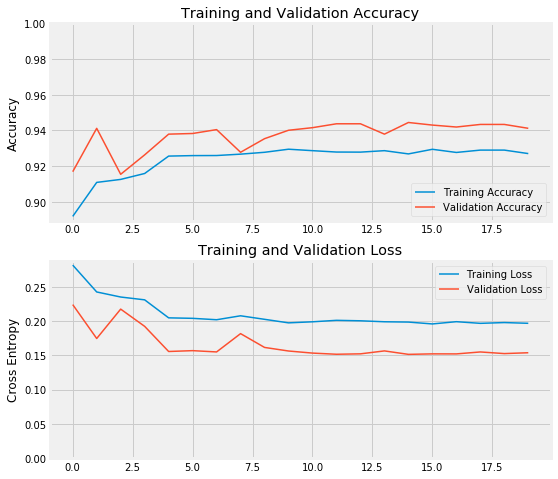

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', lw=1.5)
plt.plot(val_acc, label='Validation Accuracy', lw=1.5)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', lw=1.5)
plt.plot(val_loss, label='Validation Loss', lw=1.5)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

To confirm the evaluation metric on validation set, we can call `model.evaluate_generator()`. The output will be the performance metric, which can see from calling `model.metrics_names`.

In [35]:
STEP_SIZE_VALID = validatation_generator.n // validatation_generator.batch_size
malaria_model.evaluate_generator(generator=validatation_generator,
                                 steps=STEP_SIZE_VALID,
                                 verbose=1)

87/87 [==============================] - 84s 965ms/step - loss: 0.1528 - acc: 0.9445


[0.15277751766402145, 0.9444848]

Before we call the `predict_generator`, we need to __reset__ the testing_generator, otherwise the outcome will be in weird order.

- Because I use `softmax` activation in the output layer, the outcome will be the probabilities of 2 classes (infected vs. uninfected).
- I will use `np.argmax` to round this up to [0, 1] or the class (depends on the problem, you can manually choose the threshold manually).
- The final data frame will be built to store the image names with their references and prediction results.

In [36]:
STEP_SIZE_TEST = testing_generator.n // testing_generator.batch_size
testing_generator.reset()
predictions = malaria_model.predict_generator(testing_generator,
                                              steps=STEP_SIZE_TEST,
                                              verbose=1)
print('Sample from predictions:\n')
print(predictions[4: 8])
predicted_class = np.argmax(predictions, axis=1)
print('\n\n')
print('After formatting to class label:\n')
print(predicted_class[4: 8])

2756/2756 [==============================] - 115s 42ms/step
Sample from predictions:

[[0.9871672  0.01283287]
 [0.917361   0.08263894]
 [0.99252796 0.00747201]
 [0.97610813 0.02389187]]



After formatting to class label:

[0 0 0 0]


In [37]:
img_name = testing_generator.filenames
results = pd.DataFrame({'img_name': img_name,
                        'prediction': predicted_class})
_this = results.img_name.str.split('\\', n=1, expand=True)
results['reference'] = _this[0]
del _this
display(results.head(5))

,img_name,prediction,reference
0,Parasitized\Parasitized_C100P61ThinF_IMG_20150918_144348_cell_143.png,0,Parasitized
1,Parasitized\Parasitized_C100P61ThinF_IMG_20150918_144348_cell_144.png,0,Parasitized
2,Parasitized\Parasitized_C100P61ThinF_IMG_20150918_145422_cell_166.png,0,Parasitized
3,Parasitized\Parasitized_C100P61ThinF_IMG_20150918_145422_cell_169.png,0,Parasitized
4,Parasitized\Parasitized_C100P61ThinF_IMG_20150918_145609_cell_145.png,0,Parasitized


If we want to know what class each number is representing, we can get it via the `training_generator.class_indices`.

In [38]:
lookup_class = dict((k, v) for k, v in (training_generator.class_indices).items())
lookup_class

{'Parasitized': 0, 'Uninfected': 1}

In [47]:
results['true_label'] = results.reference.map(lookup_class)
display(results.head(5))

,img_name,prediction,reference,true_label
0,Parasitized\Parasitized_C100P61ThinF_IMG_20150918_144348_cell_143.png,0,Parasitized,0
1,Parasitized\Parasitized_C100P61ThinF_IMG_20150918_144348_cell_144.png,0,Parasitized,0
2,Parasitized\Parasitized_C100P61ThinF_IMG_20150918_145422_cell_166.png,0,Parasitized,0
3,Parasitized\Parasitized_C100P61ThinF_IMG_20150918_145422_cell_169.png,0,Parasitized,0
4,Parasitized\Parasitized_C100P61ThinF_IMG_20150918_145609_cell_145.png,0,Parasitized,0


Let's see how our model performs!!

In [42]:
confusion_matrix(results.true_label, results.prediction)

array([[1277,  100],
       [  64, 1315]], dtype=int64)

In [48]:
print('The AUC score: %.4f, accuracy score: %.4f, f1 score: %.4f' % \
      (roc_auc_score(results.true_label, results.prediction), 
       accuracy_score(results.true_label, results.prediction),
       f1_score(results.true_label, results.prediction)))

The AUC score: 0.9405, accuracy score: 0.9405, f1 score: 0.9413


#### Fine tuning

In the previous steps, what we does is actually use the convolutional base as a feature extractor and, then, add new classifier on top and only train the top-level classifier. We are __not__ updating the weights of the pre-trained network.

One way to increase the performance further is to __fine-tune__ the weights of the top layers of the pre-trained model alongside the training of the top-level classifier. The training process will force the weights to be tuned from generic features maps to features associated specifically to our malaria data set.

In the above example, we have set in `trainable` to False. If we want to train this, we have to set this to __True__. Then select only small number of top layers of the model for fine-tuning. This is because the upper layers are more specialized layers used to detect the features specific for the datasets.

In [56]:
malaria_model.trainable = True